In [4]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)

standard_params = {
    "om_b": 0.02242,
    "om_cdm": 0.11933,
    "ns": 0.9665,
    "tau_reio": 0.0561,
    "H0": 67.66,
    "sigma8": 0.8102
    #"A_s": As
}

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

######################################################
#  Configuring the run
######################################################

N = 1              #Number of basis functions in each test
zmin_pert = 300    #min and max redshift of perturbations
zmax_pert = 2500
ll_max = 2500
linear_sampling = 20000  #number of timesteps during recombination

amplitudes = np.linspace(-.1, .1, 5)
middle = int((amplitudes.shape[0]-1)/2)

Npert = 80
z_of_pert = np.linspace(zmin_pert, zmax_pert, Npert)
dz = (zmax_pert - zmin_pert)/Npert
width=dz/2.355/3.  #dz is the FWHM

plancklike=True

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["om_b"],
                   'omega_cdm':standard_params["om_cdm"],
                   #'A_s':standard_params["A_s"]
                   'sigma8': standard_params["sigma8"],
                   'n_s':standard_params["ns"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   #'recombination': 'RECFAST',
                   'perturb_xe': 'yes',
                   'xe_pert_num': N,
                   'zmin_pert': zmin_pert,
                   'zmax_pert': zmax_pert,
                   'thermo_Nz_lin': linear_sampling,
                   'xe_single_width': width
                   #'use_spline_xe_pert': 'yes'
                   }  

def create_outdir(basename):
    now = datetime.now()
    d1 = now.strftime("%b%d")
    filebase = os.path.join(os.path.dirname(os.getcwd()), 'data')+"/"+d1+"."+basename+".0"
    i=0
    while(os.path.exists(filebase)):
        split = filebase.split(".")
        filebase=".".join(split[:-1])+".{}".format(i)
        i+=1
    os.mkdir(filebase)
    print("Created directory {}".format(filebase))
    return filebase

def write_log():
    now = datetime.now()
    date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
    logname = os.path.join(filebase ,"{}.log".format(basename))
    with open(logname, 'w') as file:
        now = datetime.now()
        file.write("# Files in this directory created {}\n".format(date_time))
        file.write("{\n")
        for k,v in common_settings.items():
            file.write("{0} {1}\n".format(k,v))
        file.write("}\n")
        file.write("N {}\n".format(N))
        file.write("zmin {}\n".format(zmin_pert))
        file.write("zmax {}\n".format(zmax_pert))
        file.write("ll_max {}\n".format(ll_max))
        file.write("linear_sampling {}\n".format(linear_sampling))
        file.write("Npert {}\n".format(Npert))
        zstr = ",".join(z_of_pert.astype(str))
        file.write("pivots {}\n".format(zstr))
        file.write("dz {}\n".format(dz))
        file.write("width {}\n".format(width))
        file.write("Planck_Noise {}".format(plancklike))

M = Class.Class()
M.set(common_settings)

True

In [2]:
basename="NoiseTest"
filebase = create_outdir(basename)
write_log()

tt_derivs = []
te_derivs = []
ee_derivs = []

perts = []
z_array = []

run_count = 0
run_total = z_of_pert.shape[0]*amplitudes.shape[0]

#dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

print("{0} of {1} runs completed\r".format(run_count, run_total))

for zi in z_of_pert:
    
    M.set({'xe_single_zi': zi})

    tt_array = []
    te_array = []
    ee_array = []

    for qi in amplitudes:
        amp_str = "{}".format(qi)        #Setting up string of perturbation amplitudes
        M.set({'xe_pert_amps': amp_str}) #sets perturbation
        M.compute()

        cls = M.lensed_cl(ll_max)
        tt_array.append(cls['tt'][2:])
        te_array.append(cls['te'][2:])
        ee_array.append(cls['ee'][2:])

        if(qi==amplitudes[-1]):
            perts.append(M.get_thermodynamics()['xe_pert'])
            if(zi==z_of_pert[-1]):
                z_array.append(M.get_thermodynamics()['z'])
        
        run_count+=1
        clear_output(wait=True)
        print("{0} of {1} runs completed\r".format(run_count, run_total))

    tt_array = np.vstack(tt_array)
    te_array = np.vstack(te_array)
    ee_array = np.vstack(ee_array)
    spacing = amplitudes[1]-amplitudes[0]
    tt_grad = np.gradient(tt_array, spacing, axis=0)
    te_grad = np.gradient(te_array, spacing, axis=0)
    ee_grad = np.gradient(ee_array, spacing, axis=0)
    tt_derivs.append(tt_grad[middle])
    te_derivs.append(te_grad[middle])
    ee_derivs.append(ee_grad[middle])

tt_derivs = np.vstack(tt_derivs)    
te_derivs = np.vstack(te_derivs)    
ee_derivs = np.vstack(ee_derivs)    

z_array = np.array(z_array)

np.save(os.path.join(filebase,"tt_derivs"), tt_derivs)
np.save(os.path.join(filebase,"te_derivs"), te_derivs)
np.save(os.path.join(filebase,"ee_derivs"), ee_derivs)
np.save(os.path.join(filebase,"pivots"), z_of_pert)
np.save(os.path.join(filebase,"z"), z_array)

print("tt_derivs shape: {}".format(tt_derivs.shape))
print("te_derivs shape: {}".format(te_derivs.shape))
print("ee_derivs shape: {}".format(ee_derivs.shape))
print("zi length: {}".format(z_of_pert.shape))

400 of 400 runs completed
tt_derivs shape: (80, 2499)
te_derivs shape: (80, 2499)
ee_derivs shape: (80, 2499)
zi length: (80,)


In [6]:
M.set({'xe_single_width': width})
M.set({'xe_single_zi': zi})
M.set({'xe_pert_amps': '0'})

#varying standard parameters
for param, value in standard_params.items():
    print(param)
    dp = .05*value
    varied_params = np.linspace(-2*dp, 2*dp, 5) + value
    print(varied_params)


NameError: name 'zi' is not defined

In [3]:
M.set({'xe_single_width': width})
M.set({'xe_single_zi': zi})
M.set({'xe_pert_amps': '0'})
M.compute() ##Run CLASS
ll = np.arange(2, ll_max+1)
print(z_array.shape)
Tcmb = 1.
muK2 = (2.726e6)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

(1, 28333)


The noise properties can be described by a noise map $N_{X,\ell}^i = w_{X,i}^{-1} B_i^{-2}$ where $w_{X,i}$ is the angular resolution and $B_i = \exp{(-\ell^2 \sigma_{b,i}^2 / 2)}$ and $\sigma_b$ is the beam width for the $ith$ frequency channel. From Table 12 of [[1]](https://arxiv.org/pdf/1807.06207.pdf), we have the following values:

|                       |      143 GHz       |       217 GHz      |
|:---------------------:|:------------------:|:------------------:|
| FWHM (radians)         |       0.0021         |            0.001425   |
| $w_T^{-1/2}$ $(\mu K)$| 9.5993·10<sup>-3<sup>| 1.36·10<sup>-2<sup>|
| $w_P^{-1/2}$ $(\mu K)$| 2.042·10<sup>-2<sup>| 3.054<sup>-2<sup>|
    
To implement this, we can replace:

$$
C^X_{\ell} \to C^X_\ell + N_{X,\ell}
$$
where $N_{X,\ell} = \sum_i N^i_{X,\ell}$ is the sum over channels.


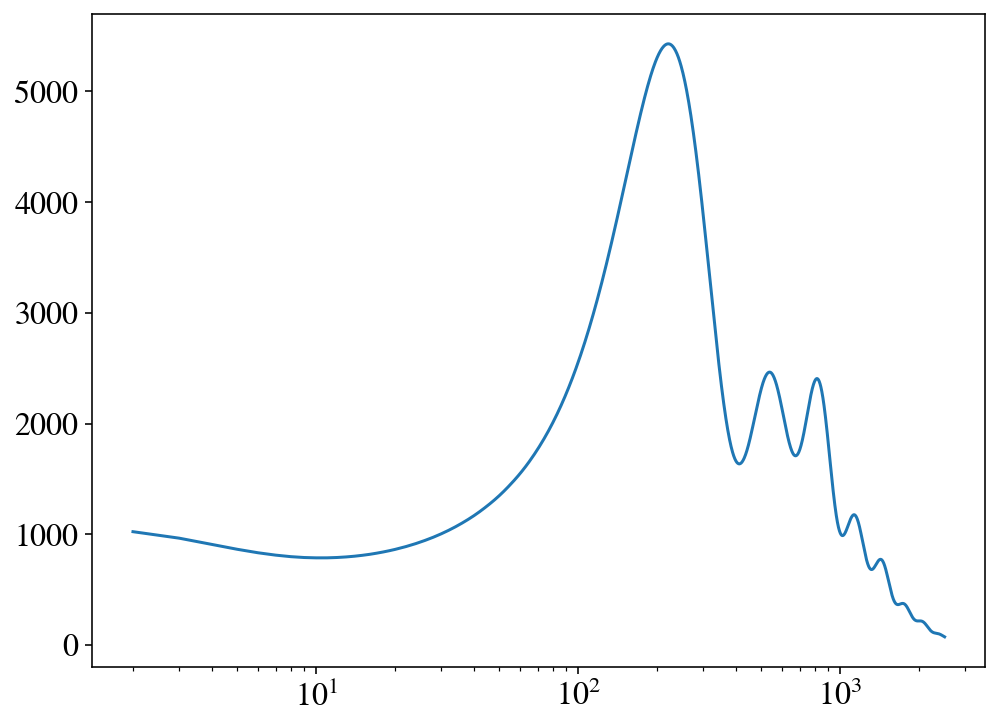

In [4]:
if(plancklike):
    beam_width_143 = (.0021)/(2*np.sqrt(2*np.log(2))) ##7.22/2.355 arcmin in radians
    beam_width_217 = (.001425)/(2*np.sqrt(2*np.log(2))) ## 4.90/2.355 arcmin in radians
    T_sens_143 = (9.5993e-3)**2 ## w^-1 micro-K^2
    T_sens_217 = (1.36e-2)**2 ## w^-1 micro-K^2
    P_sens_143 = (2.042e-2)**2 ##micro-K^2
    P_sens_217 = (3.054e-2)**2 ##micro-K^2
    B_143 = np.exp(-ll*ll*beam_width_143**2) # B^2
    B_217 = np.exp(-ll*ll*beam_width_217**2)
    #Nl_T = T_sens_143*B_143 + T_sens_217*B_217 #adding noise from both channels
    #Nl_P = P_sens_143*B_143 + P_sens_217*B_217 #adding noise from both channels
    Nl_T = 1.0/(T_sens_143**(-1.0)*B_143 + T_sens_217**(-1.0)*B_217)
    Nl_P = 1.0/(P_sens_143**(-1.0)*B_143 + P_sens_217**(-1.0)*B_217)
    row1 = np.stack([(tt_fid+Nl_T)**2, te_fid**2, (tt_fid+Nl_T)*te_fid], axis=1)
    row2 = np.stack([te_fid**2, (ee_fid+Nl_P)**2, te_fid*(ee_fid+Nl_P)], axis=1)
    row3 = np.stack([(tt_fid+Nl_T)*te_fid, te_fid*(ee_fid+Nl_P), 0.5*(te_fid**2 + (tt_fid+Nl_T)*(ee_fid+Nl_P))], axis=1)
else:
    row1 = np.stack([tt_fid**2, te_fid**2, tt_fid*te_fid], axis=1)
    row2 = np.stack([te_fid**2, ee_fid**2, te_fid*ee_fid], axis=1)
    row3 = np.stack([tt_fid*te_fid, te_fid*ee_fid, 0.5*(te_fid**2 + tt_fid*ee_fid)], axis=1)

fig,ax=plt.subplots()
ax.plot(ll, tt_fid*ll*(ll+1)/2./np.pi)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

sigmal = np.stack([row1, row2, row3], axis=1)

for i, ell in enumerate(ll):
    sigmal[i]*=(2./(2*ell + 1))

dCl = muK2*np.stack([tt_derivs, ee_derivs, te_derivs], axis=1)

In [5]:
sigma_inv = np.linalg.inv(sigmal)

In [6]:
fsky = 0.8
Fisher = fsky*np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

size = int(Npert)

(32, 25)


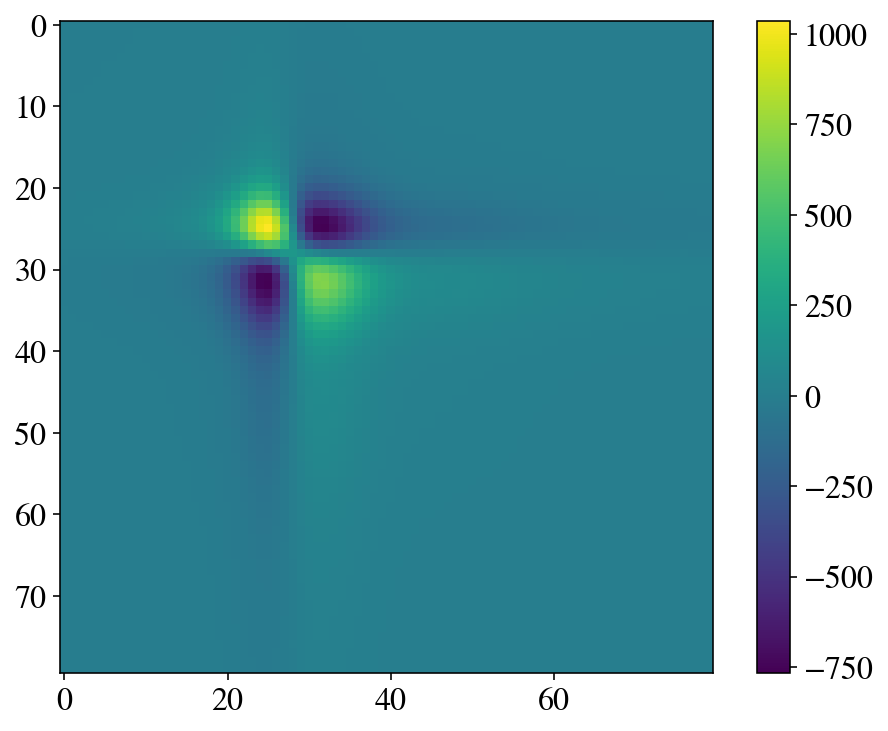

In [10]:
from matplotlib.colors import LogNorm
from matplotlib import cm

print(np.unravel_index(Fisher.argmin(), Fisher.shape))
fig,ax = plt.subplots()

m=ax.imshow(Fisher, origin='upper', cmap=cm.viridis)

fig.colorbar(m)
np.save(os.path.join(filebase,"fisher"), Fisher)